In [1]:
! pip install librosa

In [2]:
# Importing necessary libraries

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Glob to list out all the files in directory
from glob import glob
# librosa for reading wav files
import librosa
import librosa.display
import IPython.display as ipd


## TESS Dataset

# 1. Data Preparation

In [3]:
# Reading the audio files

fear_files = glob("C:/Users/prakh/Downloads/Tess_VRT_Fear_Happy_Neutral/OAF_fear/*.wav")
happy_files = glob("C:/Users/prakh/Downloads/Tess_VRT_Fear_Happy_Neutral/OAF_happy/*.wav")
neutral_files = glob("C:/Users/prakh/Downloads/Tess_VRT_Fear_Happy_Neutral/OAF_neutral/*.wav")

In [4]:
# Let's listen to a random audio file containing fear emotion

ipd.Audio(fear_files[89])

In [5]:
# Let's listen to a random audio file containing happy emotion

ipd.Audio(happy_files[87])

In [6]:
# Let's listen to a random audio file containing neutral emotion

ipd.Audio(neutral_files[76])

In [7]:
# Let's check the number of samples for each emotions

print(f"There are {len(fear_files)} number of fear samples")
print(f"There are {len(happy_files)} number of happy samples")
print(f"There are {len(neutral_files)} number of neutral samples")

There are 400 number of fear samples
There are 400 number of happy samples
There are 400 number of neutral samples


In [8]:
# Storing values of a single audio file from fear sample in a form of numpy array

y, sr = librosa.load(fear_files[0])

In [9]:
# Checking how the numpy array for the audio file appear to be at the same time checking the sample rate

print(y)
print(sr)

[ 2.9714556e-07 -1.0640829e-04 -1.0255290e-04 ...  1.1131972e-04
  1.0935357e-04  0.0000000e+00]
22050


In [10]:
# Let's append the value of all the audio files in list

audio_data = []
labels = []

# Files containing emotion of fear

for data in fear_files:
    y, sr = librosa.load(data, sr = None)
    audio_data.append(y)
    labels.append("fear")

for data in happy_files:
    y, sr = librosa.load(data, sr = None)
    audio_data.append(y)
    labels.append("happy")

for data in neutral_files:
    y, sr = librosa.load(data, sr = None)
    audio_data.append(y)
    labels.append("neutral")

In [11]:
# Now we can extract MFCC(Mel-frequency cepstral coefficients) features of the audio file, which captures the timbral and tonal qualities of the sound

def feature_extract(y, sr):
    mfccs = librosa.feature.mfcc(y = y, sr = sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis = 0)
    return mfccs

# Extracting mfcc feature for all audio files

features = [feature_extract(y, sr) for y in audio_data]

In [12]:
# Let's check mfcc feature for one of the random audio file

features[1]

array([-437.68643  ,   69.829056 ,   15.912691 ,  -18.658737 ,
        -10.559126 ,    7.7667246,  -12.29135  ,    0.69051  ,
        -15.274221 ,   -0.5725985,  -15.192065 ,  -11.290918 ,
         -3.8412955], dtype=float32)

In [13]:
# Making a dataset out of Emotions and their mfcc value

df = pd.DataFrame(features)
df["label"] = labels

In [14]:
# Checking the first five values of the dataframe, 0-12 being mfcc value and label being the target variable

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,-437.244385,60.606312,4.735497,-8.189329,1.751806,5.401639,-12.745217,-1.665546,-9.431613,0.366830,-6.095253,-12.106713,-2.660847,fear
1,-437.686432,69.829056,15.912691,-18.658737,-10.559126,7.766725,-12.291350,0.690510,-15.274221,-0.572599,-15.192065,-11.290918,-3.841295,fear
2,-445.878601,38.594421,12.448332,5.859765,7.332950,3.414988,-13.360970,-1.833906,-12.037911,-0.264680,-12.231141,-12.448788,-2.971618,fear
3,-408.698486,60.249874,10.387375,-12.225666,-3.497179,5.246919,-11.679506,0.022898,-14.138883,0.512467,-7.993771,-10.196783,-5.297758,fear
4,-489.933838,50.229900,22.550831,7.463128,9.276793,2.063001,-6.944908,2.026595,-11.649491,-5.645828,-12.395444,-13.036726,-0.823836,fear


# 2. Exploratory Data Analysis

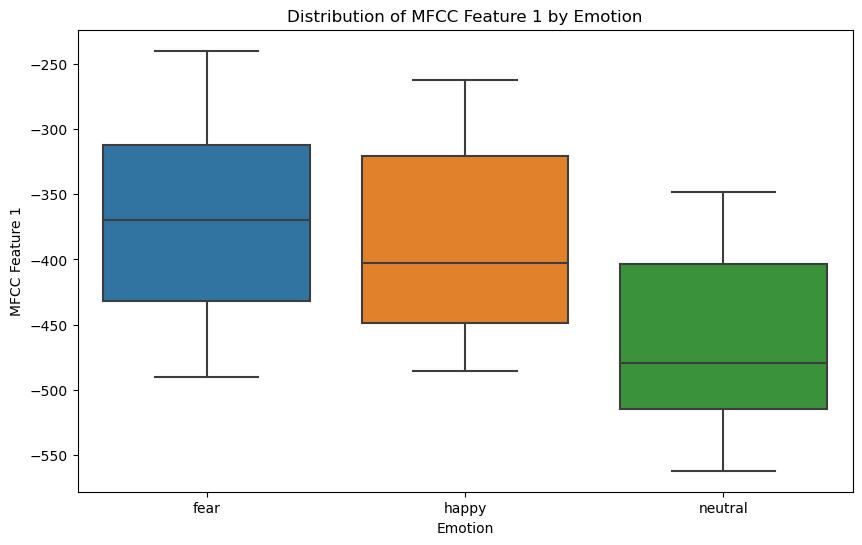

In [15]:
# Let's try to visualize different emotions mel-frequency distribution for the first coefficient

plt.figure(figsize=(10, 6))
sns.boxplot(data = df, x = "label", y = df[0])
plt.xlabel("Emotion")
plt.ylabel("MFCC Feature 1")
plt.title("Distribution of MFCC Feature 1 by Emotion")
plt.show()

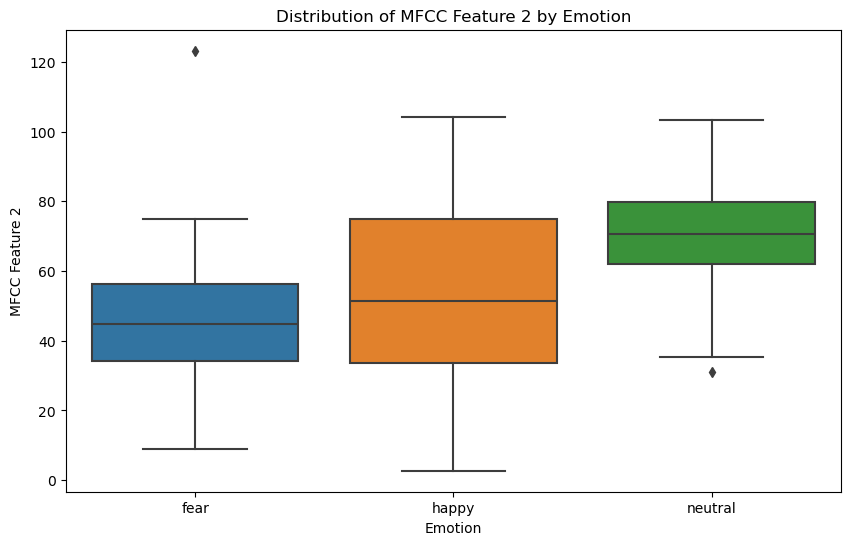

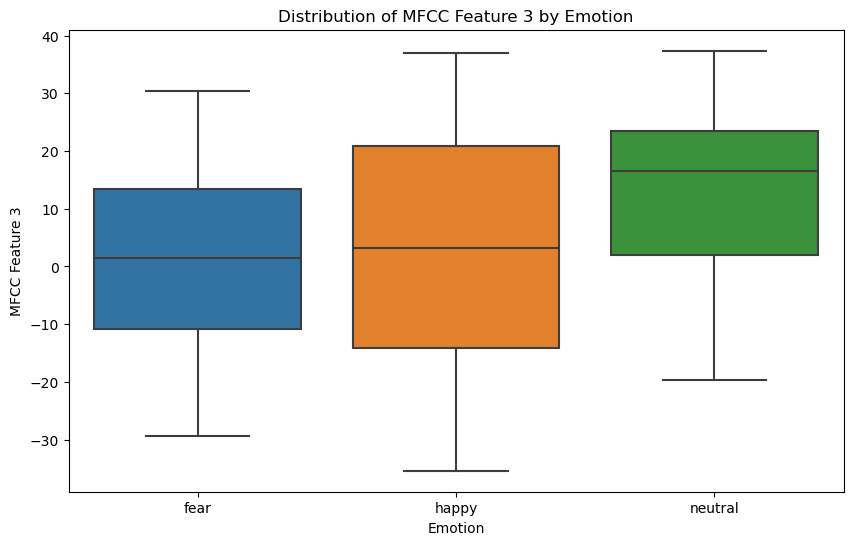

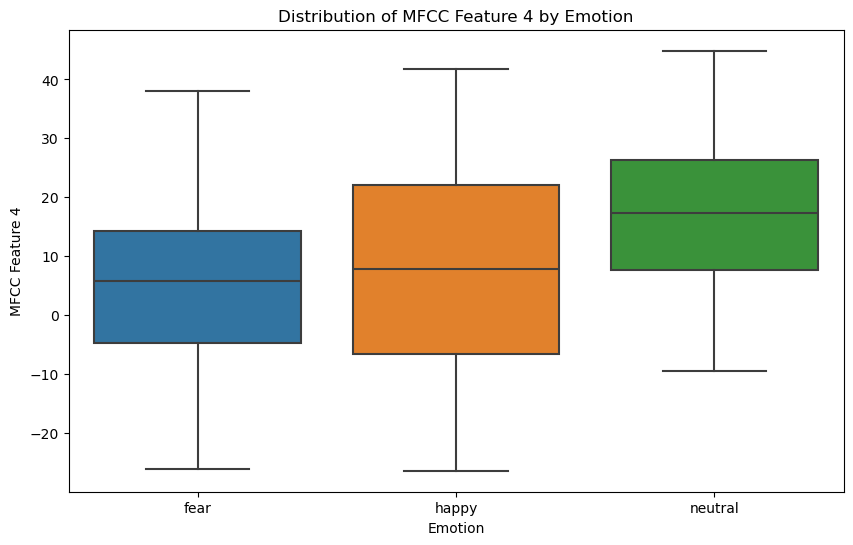

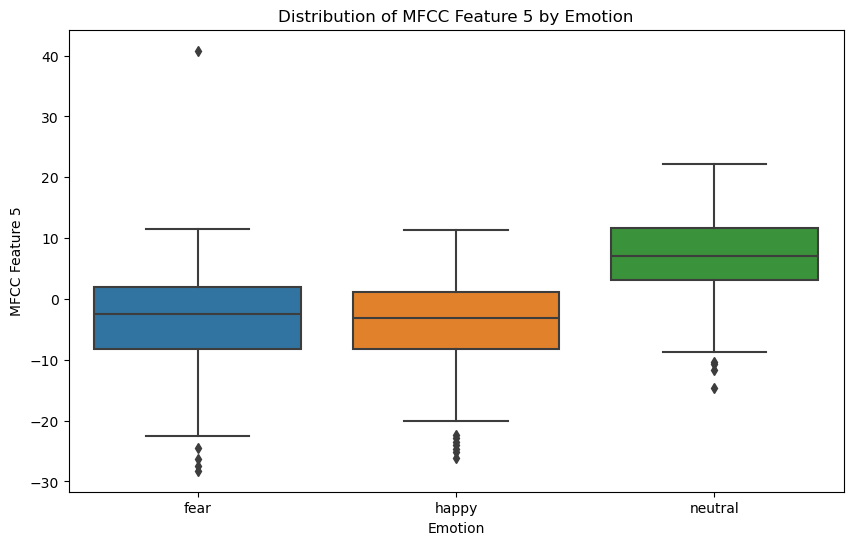

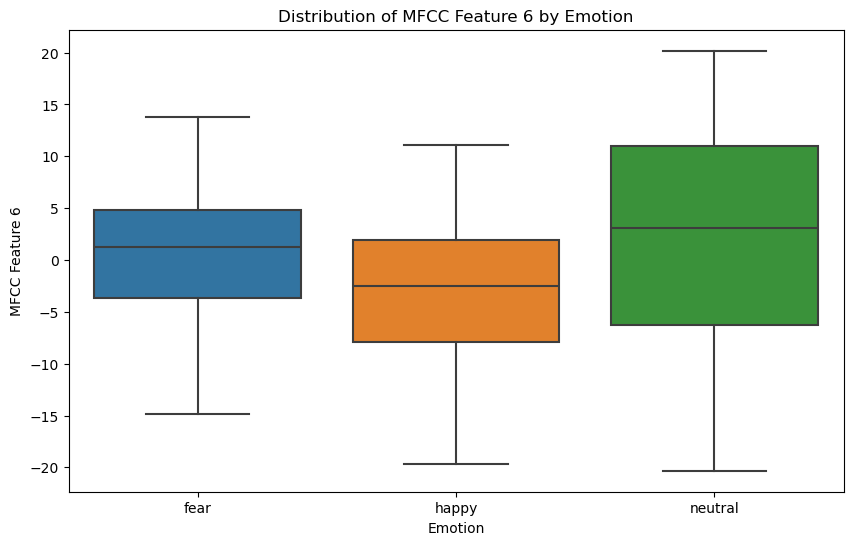

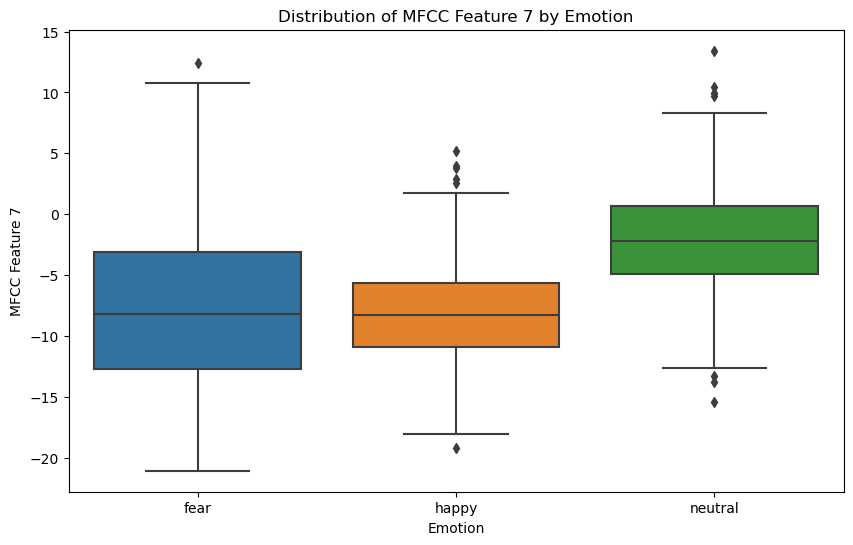

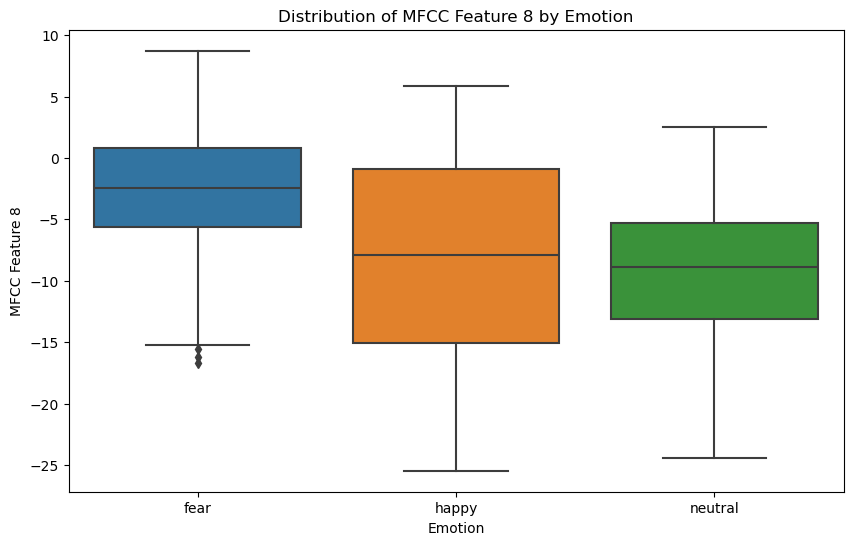

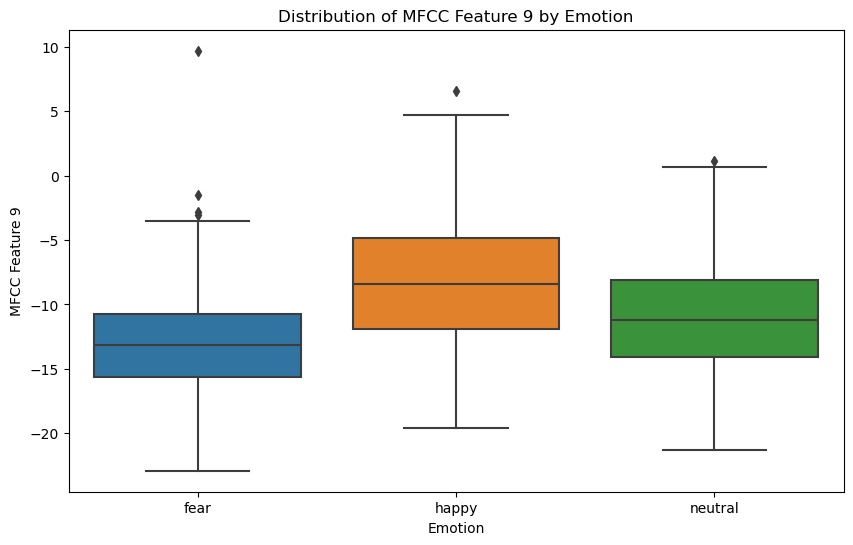

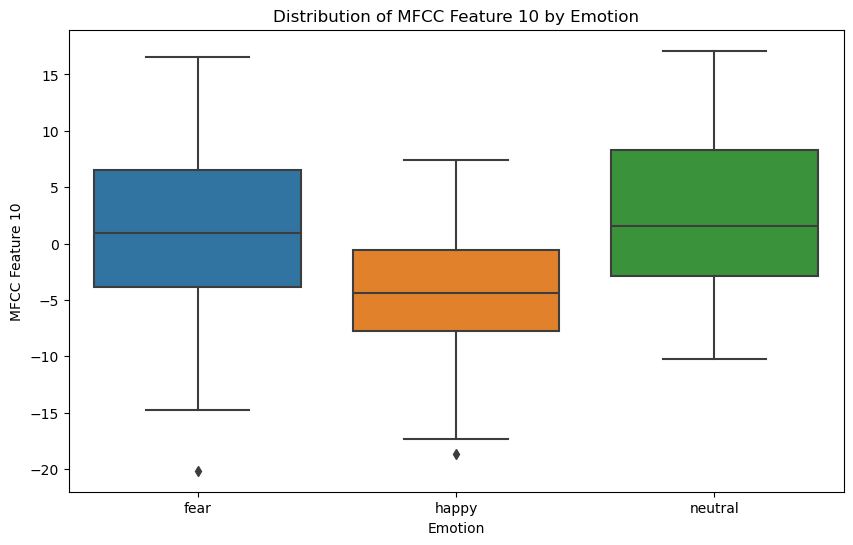

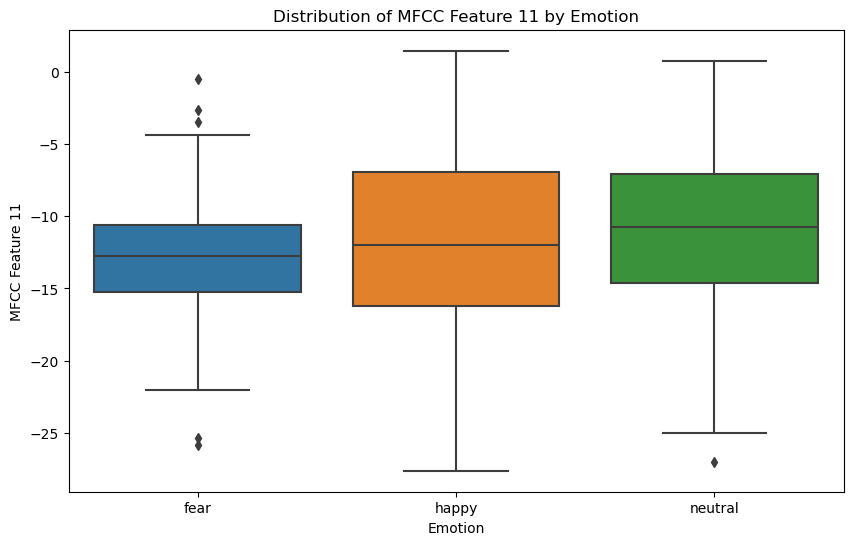

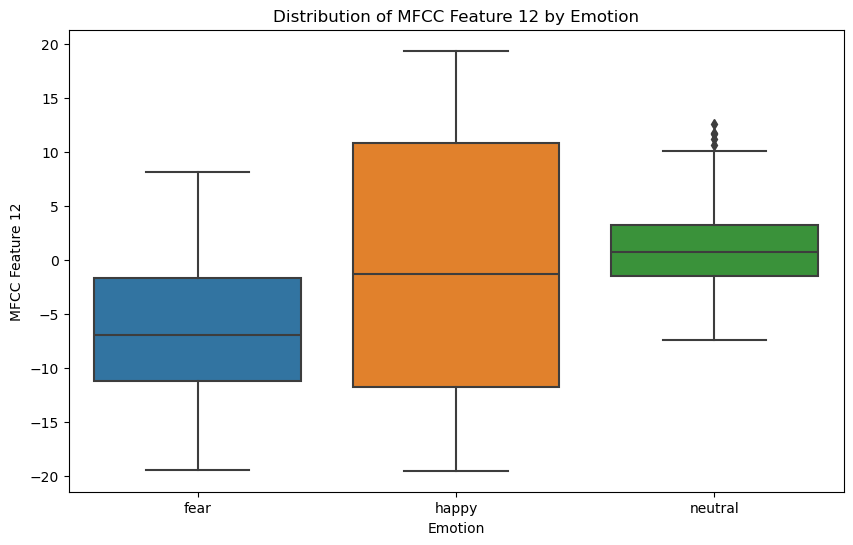

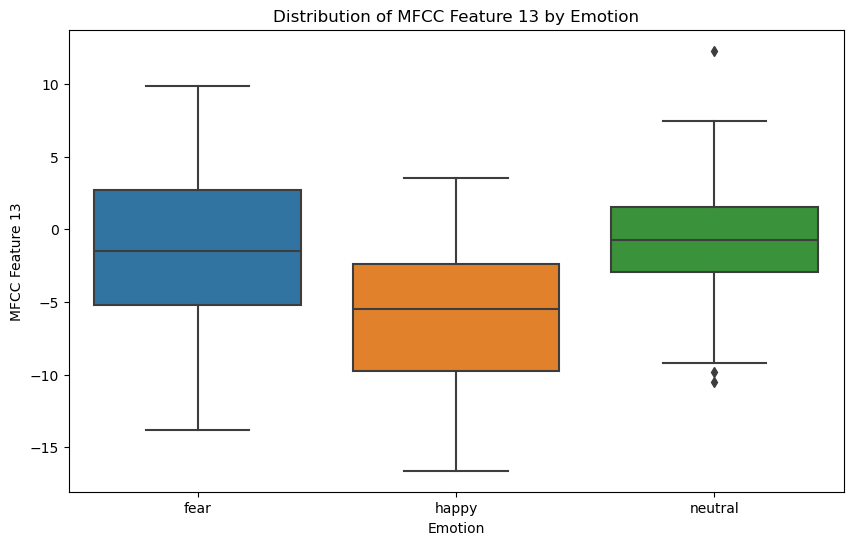

In [16]:
# Let's plot a box/whisker plot for rest of the 12 mel-frequency coefficient

for x in range(1, 13):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data = df, x = "label", y = df[x])
    plt.xlabel("Emotion")
    plt.ylabel(f"MFCC Feature {x+1}")
    plt.title(f"Distribution of MFCC Feature {x+1} by Emotion")
    plt.show()

# 3. Building ML Model

- In this case we're using SVM(Support Vector Machine) for this classification problem

In [17]:
# Let's beging by standard scaling using StandardScaler from sklearn

from sklearn.preprocessing import StandardScaler

# Standardizing MFCC features

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop("label", axis = 1))

In [18]:
# Checking for the shape of numpy array

scaled_features.shape

(1200, 13)

In [19]:
# Let's do the label encoding for the label feature, i.e. converting categories to numeric values

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(df["label"])

In [20]:
# Let's do a train-test split, we'll keep 30% of the data for testing and rest for training

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, encoded_labels, train_size=0.7, random_state=42)

# 4. SVM Model

In [21]:
# Keeping the C parameter lower to avoid overfitting though as a trade-off might have to face low training accuracy 

from sklearn.svm import SVC

# Let's first try with the linear kernel and then if required we can use RBF(Radial Basis Function) kernel afterwards

svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

# 5. Evaluating Model Performance on the Test Set

              precision    recall  f1-score   support

        fear       0.97      0.94      0.95       128
       happy       0.93      0.97      0.95       116
     neutral       0.99      0.99      0.99       116

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



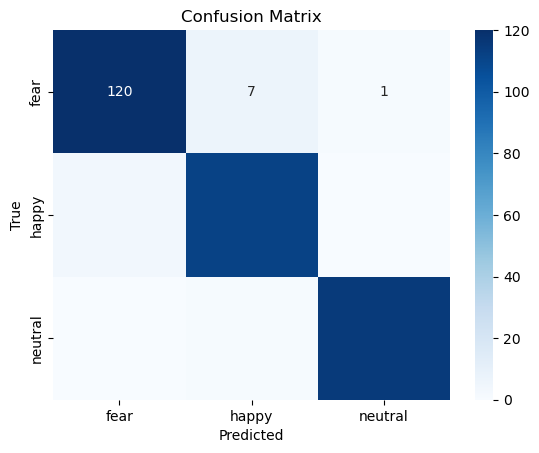

In [22]:
# Checking the Confusion matrix to check the model's accuracy

from sklearn.metrics import classification_report, confusion_matrix

y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualizing the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Checking the Cross-Validation Score of the model

from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, scaled_features, encoded_labels, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.97916667 0.92083333 0.97083333 0.95833333 0.97916667]
Mean Cross-Validation Score: 0.9616666666666667


In [25]:
# Extracting the mfcc feature for the above taken random audio file

mfcc_features = feature_extract(y, sr)

# Scaling the above taken audio file's mfcc data
mfcc_features_scaled = scaler.transform([mfcc_features])

# As the label is numeric let's first predict the label then inverse transform it into emotions using label_encoder.inverse_transform function
predicted_label = svm_model.predict(mfcc_features_scaled)
predicted_emotion = label_encoder.inverse_transform(predicted_label)

# Printing the Predicted Emotion

print("Predicted Emotion:", predicted_emotion[0].capitalize())

# Playing the chosen random audio file

ipd.Audio(audio_file)

Predicted Emotion: Fear
